In [28]:
from PIL import Image
from model import CrossviewModel
import torch.nn.functional as F
import torch
from transformers import AutoImageProcessor, AutoModel
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrossviewModel(backbone='dinov2', frozen=True).to(device)

hf_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
hf_model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)

Using cache found in C:\Users\russ_le/.cache\torch\hub\facebookresearch_dinov2_main


In [29]:
# assume model_hub: torch.hub DINOv2 loaded and model_hf loaded
img = Image.open("test.png").convert("RGB")

transform_aerial = transforms.Compose([
    transforms.Resize(
        hf_processor.size["shortest_edge"] 
            if "shortest_edge" in hf_processor.size 
            else tuple(hf_processor.size.values()),
        interpolation=transforms.InterpolationMode.BICUBIC,
        antialias=True
    ),
    transforms.CenterCrop(hf_processor.crop_size["height"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=hf_processor.image_mean,
                         std=hf_processor.image_std)
])

transform_aerial = transforms.Compose([
    transforms.Resize(
        256,
        interpolation=transforms.InterpolationMode.BICUBIC,
        antialias=True
    ),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=hf_processor.image_mean,
                         std=hf_processor.image_std)
])   

# hub preprocessing (your Dinov2Matcher.transform)
img_tensor = transform_aerial(img).unsqueeze(0).to(device)

# HF preprocessing
inputs = hf_processor(images=img, return_tensors="pt").to(device)

with torch.no_grad():
    tokens = model(img_tensor, img_tensor)[0]  # [1, 1+N, C]
    # tokens_hf = hf_model(**inputs).last_hidden_state  # [1, 1+num_reg+N, C]
    tokens_hf = hf_model(img_tensor).last_hidden_state  # [1, 1+num_reg+N, C]

# align indices (skip register tokens if present)
num_reg = getattr(hf_model.config, "num_register_tokens", 0)
print("num_reg:", num_reg)  # num_reg = 0 for dinov2-base
tokens_hf = tokens_hf[:, 1+num_reg:, :]

# move to cpu
tokens = tokens.cpu()
tokens_hf = tokens_hf.cpu()

print("th shape:", tokens.shape)
print("tf shape:", tokens_hf.shape)

# resize to same N if needed, or just compare first min(N)
Nmin = min(tokens.shape[1], tokens_hf.shape[1])
sim = F.cosine_similarity(tokens[:, :Nmin, :], tokens_hf[:, :Nmin, :], dim=-1).mean()
print("mean token cos sim:", sim.item())

num_reg: 0
th shape: torch.Size([1, 256, 768])
tf shape: torch.Size([1, 256, 768])
mean token cos sim: 1.0


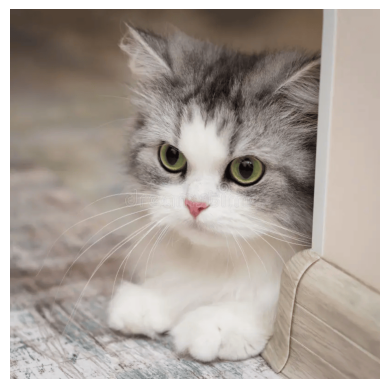

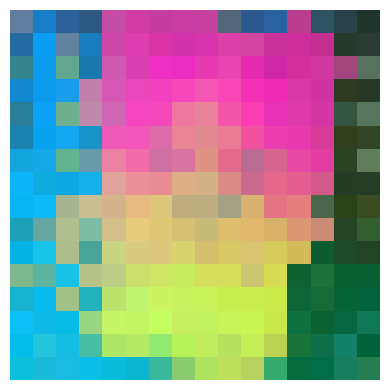

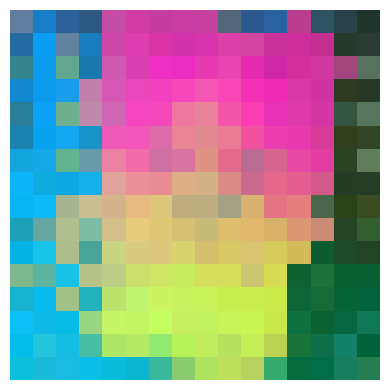

In [30]:
# show image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')

model.show_tokens(tokens)
model.show_tokens(tokens_hf)

In [31]:
print(hf_processor.size["shortest_edge"] 
            if "shortest_edge" in hf_processor.size 
            else tuple(hf_processor.size.values()))

print(hf_processor.crop_size["height"])

256
224
